# MACD Trading Model

Import packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas_datareader as pdr
from datetime import date

from trading_tools import MACD_Model

In [2]:
sns.set_context("notebook")

## 1. Backtesting

For my model I picked Erste Bank AG stock to trade, as it is quite volatile and has interesting patterns in it. I didn't pick any ETFs, because I wanted to test how mmy model would handle risky asset with volatile periods. Austrian market is quite illiquid as well, so it is an interesting case to study by using such a model. 

In [3]:
stock = yf.download('EBS.VI',start = "1980-01-01",end = "2025-01-01")

[*********************100%***********************]  1 of 1 completed


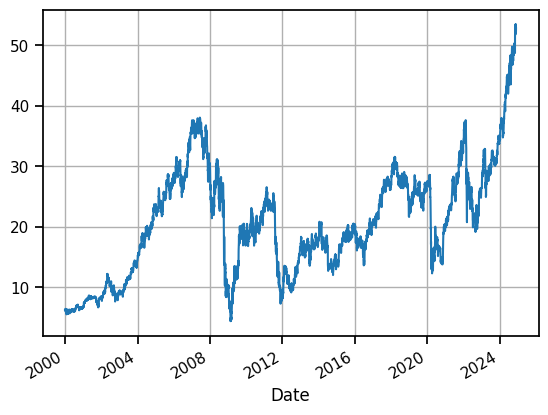

In [4]:
stock['Adj Close'].plot()
plt.grid()

Let's analyse the strategy: we have two thresholds $MA_l$ and $MA_s$ for length of moving average window that would be adjustable and tunable later in `MACD_Model`

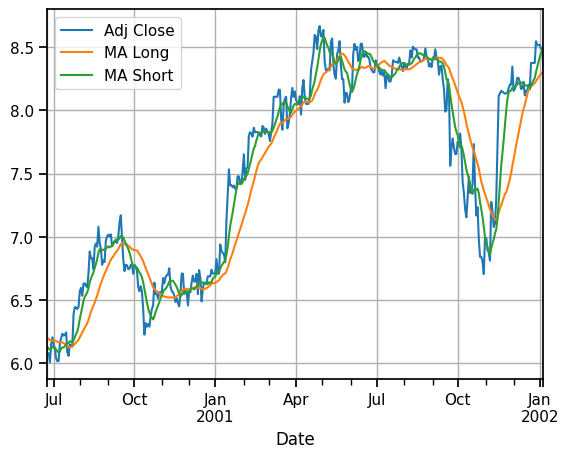

In [5]:
stock['MA Long'] = stock['Adj Close'].rolling(window=26).mean()
stock['MA Short'] = stock['Adj Close'].rolling(window=9).mean()
stock.dropna(inplace=True)
stock.iloc[100:500][['Adj Close','MA Long', 'MA Short']].plot()
plt.grid()

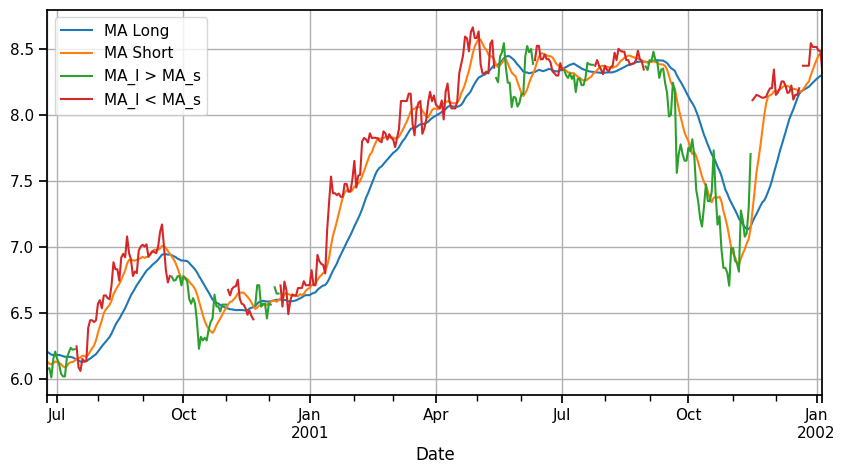

In [6]:
stock['MA_l > MA_s'] = np.where(stock['MA Long'] > stock['MA Short'], stock['Adj Close'], None)
stock['MA_l < MA_s'] = np.where(stock['MA Long'] < stock['MA Short'], stock['Adj Close'], None)
stock.iloc[100:500][['MA Long', 'MA Short', 'MA_l > MA_s', 'MA_l < MA_s']].plot(figsize=(10,5))
stock.drop(['MA_l < MA_s','MA_l > MA_s'],axis=1,inplace=True)
plt.grid()

Use developed model and train the hyperparameters $MA_l, MA_s$

In [7]:
model = MACD_Model(stock)
optimized_params = model.tune('2000','2012')

sharpe 0.16373279832467794 [20.  5.]
sharpe 0.26485871122848076 [20.   16.25]
sharpe 0.2753294050648159 [80.  5.]
sharpe 0.3745628840872973 [80.   16.25]
sharpe 0.4332581834706985 [80. 50.]
return 0.07477659270280812 [20.  5.]
return 0.09891952865301734 [20.   16.25]
return 0.11797615228628766 [80.   16.25]
return 0.12696127557947956 [80. 50.]
volatility 0.21887274574025645 [20.  5.]
volatility 0.21306309739978 [80.  5.]
volatility 0.21100917917461604 [80.   16.25]
volatility 0.20499700041421232 [80.  27.5]
volatility 0.20311163210291075 [80.         49.99999072]
volatility 0.20012491837340068 [199.99999565   5.        ]
Optimized parameters for:
Sharpe Ratio:  [80. 50.]
Return:  [80. 50.]
Volatility:  [199.99999565   5.        ]


In [8]:
PARAMS = np.round(optimized_params)[0]

In [9]:
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2014','2024')

Analyse the metrics(ann. return, ann. volatility, Sharpe ratio(composed from ann.ret. and ann.vol.)) on the test interval 2014-2024. Returns are quite low, but later I show that volatility is actually lower than if Buy and Hold strategy on this stock would be used(even though I use parameters for bigger Sharpe ratio in this and later examples)

In [10]:
metrics.ret,metrics.vol,metrics.sr

(0.039245341600756545, 0.1818053928091198, 0.1879770506448282)

~4% is an actually good result, keeping in mind we are dealing with Austrian market(average inflation rate in this period is <a href="https://tradingeconomics.com/austria/inflation-cpi">lower than 4%</a>) 

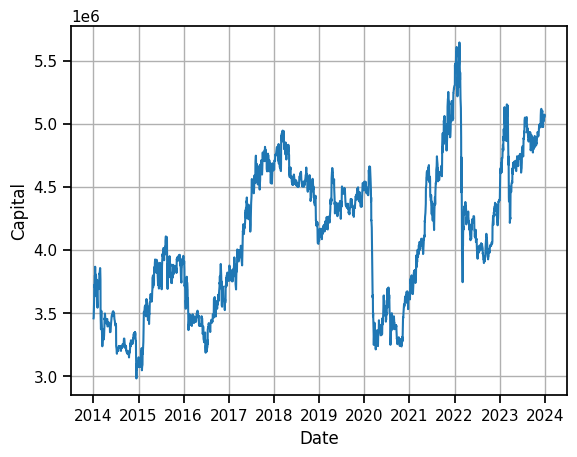

In [11]:
sns.lineplot(simulation_results,x=simulation_results.index,y='Capital')
plt.grid()

Buy and Hold: volatility is higher than MACD model's volatility and Sharpe ratio is higher. 

[*********************100%***********************]  1 of 1 completed


(0.06964334253521987, 0.34434696376689217, 0.10060591839186911)

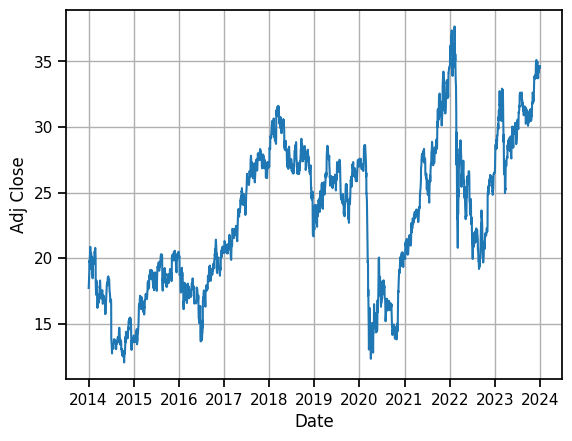

In [12]:
ebs_14_24 = yf.download('EBS.VI',start = "2014-01-01",end = "2024-01-01")
ret = ebs_14_24['Adj Close'].pct_change().dropna()

years = ebs_14_24.shape[0]/252
totret = (ret + 1).prod() - 1
annret = (1 + totret) ** (1 / years) - 1

vol = ret.std()
annvol = vol * np.sqrt(252)

rf = 0.035
sr =  (annret - rf) / annvol 

sns.lineplot(ebs_14_24,x=ebs_14_24.index,y='Adj Close')
plt.grid()
annret,annvol,sr

Let's see what happens on train data: 

Model metrics: 0.12691696727148516 0.20316137899258466 0.4331043502053853


[*********************100%***********************]  1 of 1 completed

Buy and Hold: 0.03397021514007803 0.434331472226992 0.07821264935257648


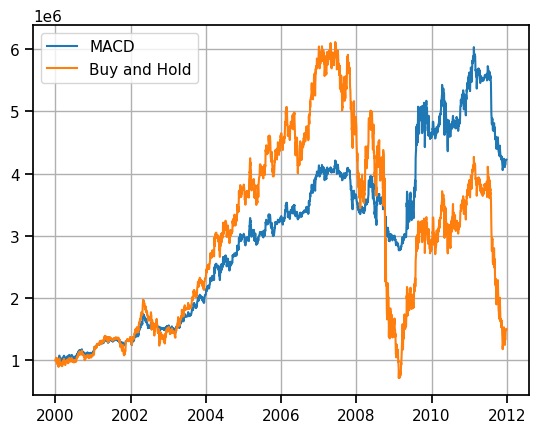

In [13]:
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2000','2012')
print('Model metrics:',metrics.ret,metrics.vol,metrics.sr)
plt.plot(simulation_results['Capital'],label='MACD')

ebs_14_24 = yf.download('EBS.VI',start = "2000-01-01",end = "2012-01-01")
ret = ebs_14_24['Adj Close'].pct_change().dropna()

years = ebs_14_24.shape[0]/252
totret = (ret + 1).prod() - 1
annret = (1 + totret) ** (1 / years) - 1

vol = ret.std()
annvol = vol * np.sqrt(252)

rf = 0 # Risk free rate for Buy and Hold, use 0 for simplicity
sr =  (annret - rf) / annvol 

import yaml 
with open('config.yaml') as file: 
    config = yaml.safe_load(file)

plt.plot(ebs_14_24['Adj Close']/ebs_14_24['Adj Close'].iloc[0]*config['initial_capital'],label='Buy and Hold')
plt.grid()
plt.legend()
print('Buy and Hold:',annret,annvol,sr)

All metrics of our model are much more better. This however was used as an example and shouldn't showcase peformance of a real model, as the tuning of hyperparameters might be overfitted

Performance on the entire timeframe: 

(0.0936656290957174, 0.1961870641997372, 0.3613293649291446)

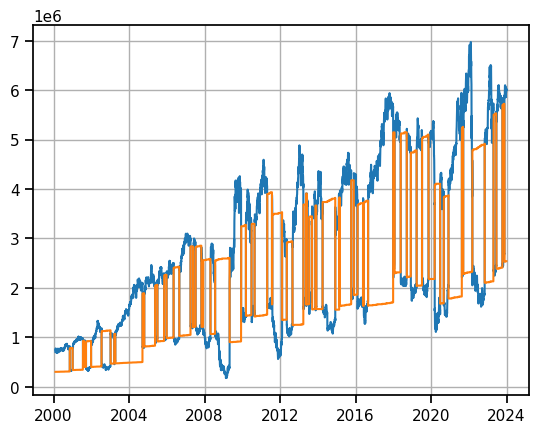

In [14]:
model = MACD_Model(stock)
model.set_params(PARAMS)
simulation_results,metrics = model.run_simulation('2000','2024')
plt.plot(simulation_results['Asset'])
plt.plot(simulation_results['Cash'])
plt.grid()
metrics.ret,metrics.vol,metrics.sr

Here are cash and asset parts of whole capital plotted as well 

## 2. Monte Carlo simulations

Formula for future returns derived from Brownian motion equations: $$X_{t+\Delta t} = X_t e^{(\mu-\frac{\sigma^2}{2})\Delta t+\sigma \varepsilon _t\sqrt\Delta t}$$

In [15]:
def simulate_MC(x,mu,sigma,t=252,dt=1): 
    X_t = x
    drift = mu*dt 
    eps = np.random.normal(mu,sigma,t)
    res = []
    for i in range(t):
        diff = sigma*eps[i]*np.sqrt(dt)
        X_t_dt = X_t*np.exp(drift+diff-sigma**2/2)
        res.append(X_t_dt)
        X_t = X_t_dt
    return res 

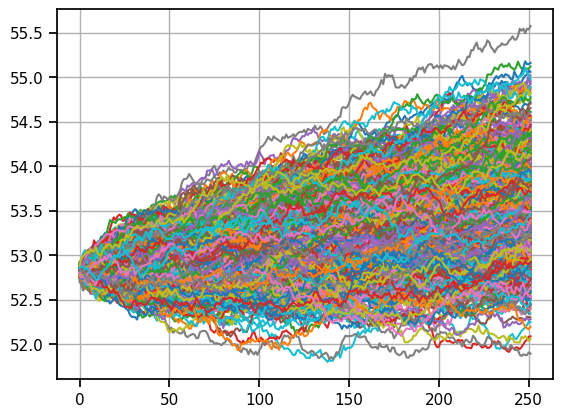

In [16]:
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

for _ in range(1000):
    plt.plot(simulate_MC(x,mu,sigma))
plt.grid()

One more time, but with previous adj. close prices(simulated paths are not accurate, but still can be used for our analysis)

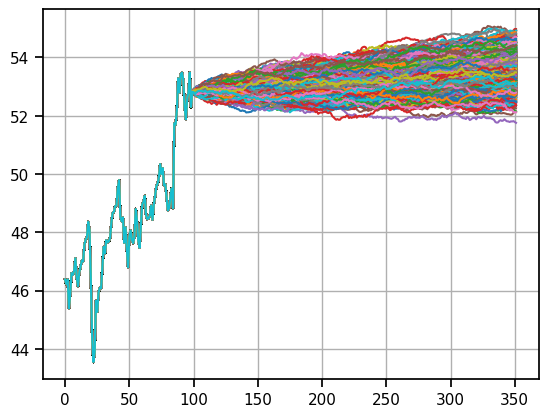

In [17]:
stock_pred=stock.iloc[:,-100:].copy()
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

for _ in range(1000):
    stock_pred=stock.iloc[-100:]['Adj Close'].copy()
    stock_pred = pd.concat([stock_pred,pd.Series(simulate_MC(x,mu,sigma))])
    stock_pred.reset_index(drop=True).plot()
plt.grid()

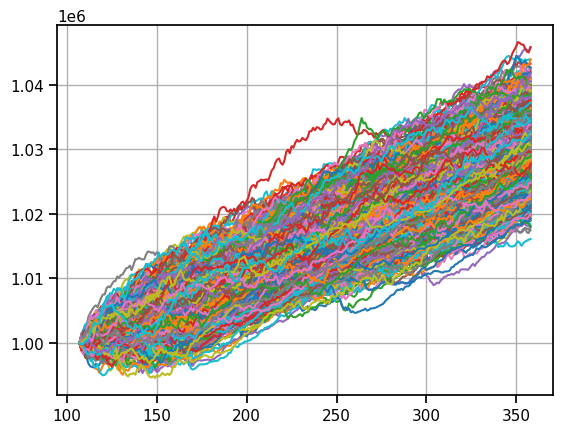

In [18]:
mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
sigma = stock['Adj Close'].pct_change().dropna().std()
x = stock.iloc[-1]['Adj Close']

def var_historic(data: pd.DataFrame, level = 99):
    return -np.percentile(data, (100 - level))
def cvar_historic(data: pd.DataFrame, level = 99):
    is_beyond = data <= -var_historic(data, level = level)
    return -data[is_beyond].mean()

returns = []
var_cvar = []

for _ in range(1000):
    gen_df = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma)})

    df = pd.concat([stock.reset_index(), gen_df])[-360:-1].reset_index()[['Adj Close']]
    df['MA Long'] = df['Adj Close'].rolling(window=int(PARAMS[0])).mean()
    df['MA Short'] = df['Adj Close'].rolling(window=int(PARAMS[1])).mean()
    df = df.iloc[-252:]
    
    model_mc = MACD_Model()
    model_mc.ir_const = True
    sim,_ = model_mc.run_simulation(data=df)
    rets = sim['Capital'].pct_change().dropna()
    var_cvar.append([var_historic(rets),cvar_historic(rets)])
    returns.append(-model_mc.calculate_metrics('return'))
    sim['Capital'].plot()
plt.grid()

(array([  0.84188648,   4.20943239,   6.73509183,  12.62829718,
         25.25659436,  42.09432393,  49.67130223,  60.61582645,
         63.98337237, 106.91958277,  86.71430729,  70.7184642 ,
         59.77393998,  58.9320535 ,  59.77393998,  25.25659436,
         31.99168618,  21.04716196,  14.31207014,  16.83772957,
         10.94452422,   5.05131887,   4.20943239,   1.68377296,
          1.68377296]),
 array([0.01610385, 0.01729166, 0.01847947, 0.01966728, 0.02085508,
        0.02204289, 0.0232307 , 0.02441851, 0.02560632, 0.02679413,
        0.02798194, 0.02916974, 0.03035755, 0.03154536, 0.03273317,
        0.03392098, 0.03510879, 0.0362966 , 0.0374844 , 0.03867221,
        0.03986002, 0.04104783, 0.04223564, 0.04342345, 0.04461126,
        0.04579906]),
 <BarContainer object of 25 artists>)

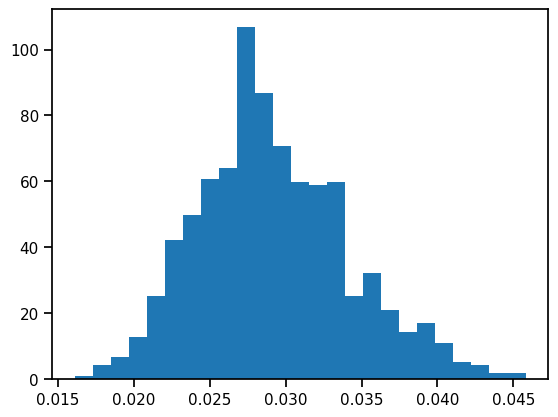

In [19]:
plt.hist(returns,25,density=1)

From the distribution and model performance(see graph) one can derive that model trades successfully on predicted data. 

In [20]:
np.mean(var_cvar,axis=0)

array([0.00082378, 0.00094982])

## 3. FED Scenario Analysis

In [21]:
today = date.today()

In [22]:
def transform_returns(data,n_cols):
    '''
    Help function to transform data into annualized returns
    '''
    n_rows = int(np.ceil(len(data) / n_cols))
    total_elements = n_rows * n_cols
    padded_vector = np.pad(data, (0, total_elements - len(data)), 'constant')
    r = padded_vector.reshape(n_rows, n_cols).T
    ret = np.prod(r+1,axis=0) ** (1/252) -1
    return ret 

Here I use German market indicator DAX, as it is as close as I can get to Austrian without dealing with missing values of eariler periods

In [23]:
dax = yf.download('DAX',start = '2015-01-01',end = today)
dax['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


Date
2015-01-05   -0.049039
2015-01-06    0.000000
2015-01-07    0.000000
2015-01-08    0.028135
2015-01-09    0.000000
                ...   
2024-11-13   -0.013653
2024-11-14    0.011381
2024-11-15    0.000608
2024-11-18    0.002432
2024-11-19   -0.008490
Name: Adj Close, Length: 2487, dtype: float64

In [24]:
dax[dax.index >= '2024'].shape[0] # note that 2024 is not over :-(, use this number instead of 252 to be more precise for ann.ret. calculation

224

In [25]:
dax_r = np.array(dax['Adj Close'].pct_change().dropna())
ret_m = transform_returns(dax_r,252)

In [26]:
ebs = yf.download('EBS.VI',start = "2015-01-01",end = today)
ebs_r = np.array(ebs['Adj Close'].pct_change().dropna())

ret = transform_returns(ebs_r,252)

[*********************100%***********************]  1 of 1 completed


In [27]:
rf = pd.DataFrame(pdr.DataReader('FEDFUNDS', 'fred',start = "2015-01-01",end = today) / 100)
rf

,FEDFUNDS
DATE,
2015-01-01,0.0011
2015-02-01,0.0011
2015-03-01,0.0011
2015-04-01,0.0012
2015-05-01,0.0012
...,...
2024-06-01,0.0533
2024-07-01,0.0533
2024-08-01,0.0533


In [28]:
rf_r = transform_returns(rf.FEDFUNDS,12)

In [29]:
adj_a_r = ret - rf_r
adj_m_r = ret_m - rf_r

Regress adj.asset returns on adj. market returns using least squares(lin.regressor can be used as well, but in this case with 10x1 data let's use the simpler one as one is based on another)

In [30]:
b, residuals, rank, s = np.linalg.lstsq(np.atleast_2d(adj_m_r).T, np.atleast_2d(adj_a_r).T, rcond=None)

In [31]:
BETA = b[0,0]
BETA

0.7505451738142214

In [32]:
r_m_last = ret_m[-1]
r_f_last = rf.iloc[-1].FEDFUNDS

In [33]:
def get_rf(bp,p,n_path): 
    v = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])
    dist = v * bp * 1e-4 
    return dist + (r_f_last+1)**(1/252) - 1 
get_rf(25,0.6,1000) 

array([[0.0026872, 0.0001872],
       [0.0026872, 0.0001872],
       [0.0001872, 0.0001872],
       ...,
       [0.0001872, 0.0001872],
       [0.0001872, 0.0026872],
       [0.0001872, 0.0026872]])

In [34]:
def fed_sim(bp,p,n_path): 
    '''
    Function for simulation of FED dropping/raising interest rates
    '''
    rf = get_rf(bp,p,n_path)

    mu = ((ebs['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
    sigma = ebs['Adj Close'].pct_change().dropna().std()
    capital = []
    asset = []
    for i in range(n_path):

        m = rf[i] + BETA * ((r_m_last+1)**(1/dax[dax.index >= '2024'].shape[0])-1-rf[i])

        x = ebs.iloc[-1]['Adj Close']
        df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
        x = df1['Adj Close'].iloc[-1]

        x += x*m[0]

        df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
        x = df2['Adj Close'].iloc[-1]

        x += x*m[1]

        df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})


        gen_df = pd.concat([ebs[-200:],df1,df2,df3]).reset_index()
        gen_df['MA Long'] = gen_df['Adj Close'].rolling(window=int(PARAMS[0])).mean()
        gen_df['MA Short'] = gen_df['Adj Close'].rolling(window=int(PARAMS[1])).mean()
        gen_df = gen_df[200:].reset_index(drop=True)

        asset.append(list(gen_df['Adj Close']))

        model_mc = MACD_Model()
        model_mc.ir_const = True 
        model_mc.ir = r_f_last

        
        sim1,_ = model_mc.run_simulation(data=gen_df[:84])
        model_mc.ir = m[0]

        sim2,_ = model_mc.run_simulation(data=gen_df[84:168])
        model_mc.ir = m[1]

        sim3,_ = model_mc.run_simulation(data=gen_df[168:])
        sim_df = pd.concat([sim1,sim2,sim3]).reset_index(drop=True)

        capital.append(sim_df['Capital'])
        plt.plot(sim_df['Capital']) 
    return np.array(capital),np.array(asset)

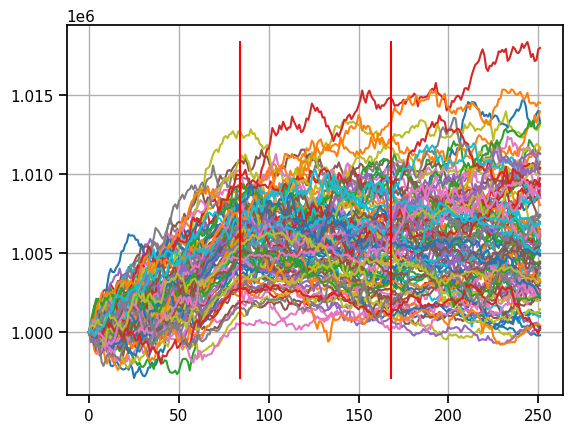

In [35]:
cap,_ = fed_sim(25,0.6,100)
plt.plot([84,84],[cap.min(),cap.max()],c='r')
plt.plot([168,168],[cap.min(),cap.max()],c='r')
plt.grid()

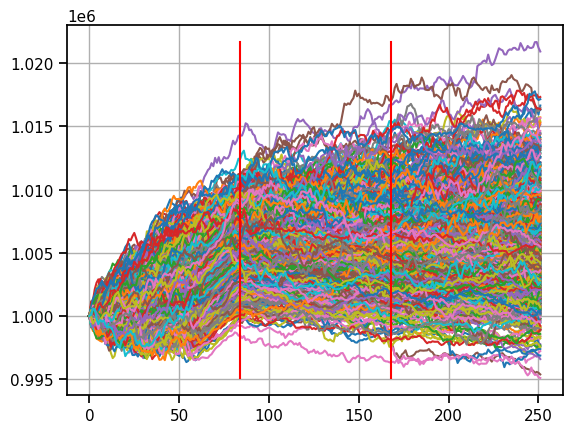

In [36]:
cap,asset = fed_sim(-25,0.7,1000)
plt.plot([84,84],[cap.min(),cap.max()],c='r')
plt.plot([168,168],[cap.min(),cap.max()],c='r')
plt.grid()

<small>I left this commented code for history :-)</small>

In [37]:
# def fed_sim(bp,p,n_path): 
#     dist = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])

#     mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
#     sigma = stock['Adj Close'].pct_change().dropna().std()
#     results = []
#     for i in range(n_path):
        
#         x = stock.iloc[-1]['Adj Close']
#         df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df1['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df2['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})

#         gen_df = pd.concat([df1,df2,df3]).reset_index()
#         results.append(list(gen_df['Adj Close']))
#         gen_df['Adj Close'].plot()

#     result = np.array(results)

#     plt.plot([84,84],[result.min(),result.max()],c='r')
#     plt.plot([168,168],[result.min(),result.max()],c='r')

#     return result

In [38]:
# def fed_sim_model(bp,p,n_path): 
#     dist = np.random.choice([1, 0], size=(n_path,2), p=[p, 1-p])

#     mu = ((stock['Adj Close'].pct_change().dropna()+1).prod())**(1/stock.shape[0])-1
#     sigma = stock['Adj Close'].pct_change().dropna().std()
#     for i in range(n_path):
        
#         x = stock.iloc[-1]['Adj Close']
#         df1 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df1['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df2 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})
#         x = df2['Adj Close'].iloc[-1]
#         dx = bp * x * dist[i][0] * 1e-4
#         x += dx
#         df3 = pd.DataFrame({'Adj Close': simulate_MC(x,mu,sigma,t=84)})

#         gen_df = pd.concat([df1,df2,df3]).reset_index()

#         model_mc = MACD_Model(gen_df)
#         model_mc.set_params([200,5])
#         sim,_,_ = model_mc.run_simulation(0,-1)
#         sim['Capital'].plot()

#     plt.plot([84,84],[9.9e5,10.5e5])
#     plt.plot([168,168],[9.9e5,10.5e5])